### HW2b, Jordan Gittleman

We can continue the previous project as we explained in class by using a feature detector instead of manually picking the points. 

1.	Use a Harris corner or a SIFT feature detector and then match those points using the brute force matcher. How many points would you pick? \
(a)	Use SVD to compute a homography on the overconstrained linear equations that the feature points imply. Remake the mosaic. \
(b)	Now use the cv2.homography with Ransac on the src and dst points after you match the feature points and remake the mosaic. 


In [1]:
import os
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple


First lets import the same images as before but at a lower resolution, This allow for better quality points without havbing to use a crazy huge amount.

In [108]:
# image_paths=['1.jpg','2.jpg','3.jpg','4.jpg','5.jpg']
image_paths=['h1.jpg','h2.jpg','h3.jpg','h4.jpg','h5.jpg']
images=[]
for image in image_paths:
    img = cv2.imread(image)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (0,0), fx=.1, fy=.1)
    images.append(img)

Next, lets initialize our SIFT feature detector and find some points in two images

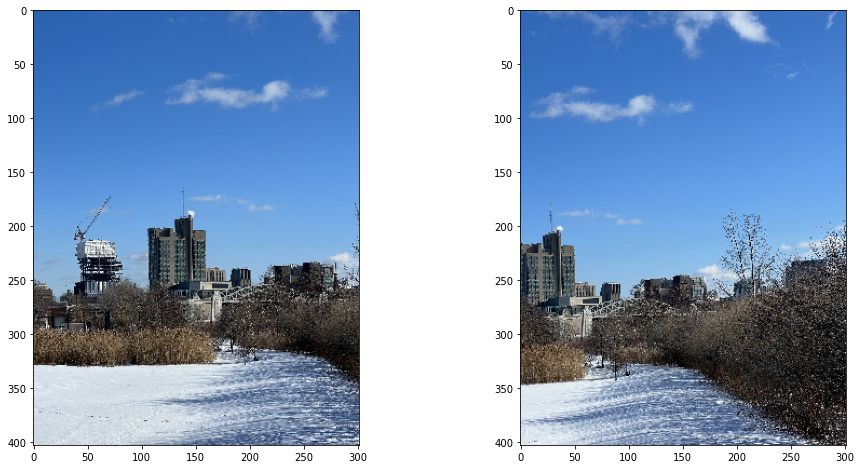

In [109]:
img1 = images[0]
img2 = images[1]
figure, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img2)
ax[1].imshow(img1) 

Here are our images we'll be comparing

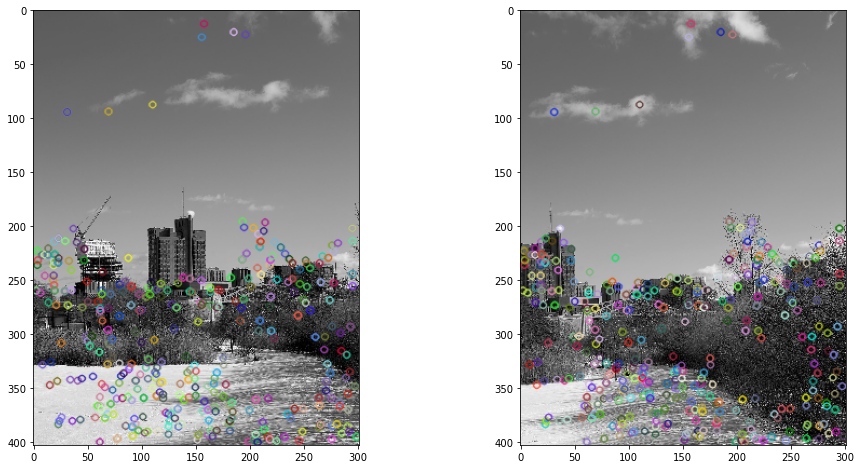

In [110]:

gray1 = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY) # need to convert to grayscale for SIFT


gray2 = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY) #

sift = cv2.SIFT_create(2000) #create our detector
keypoints1, descriptors1 = sift.detectAndCompute(img1,None) # detect keypoints and compute descriptors
keypoints2, descriptors2 = sift.detectAndCompute(img2,None) 

img1 = cv2.drawKeypoints(gray1,keypoints1,img1) # draw the points
img2 = cv2.drawKeypoints(gray2,keypoints1,img2)

figure, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img2)
ax[1].imshow(img1)

Based on running sift on these images, we have quite a few detections, lets compare between the two images

Found 153 matches!


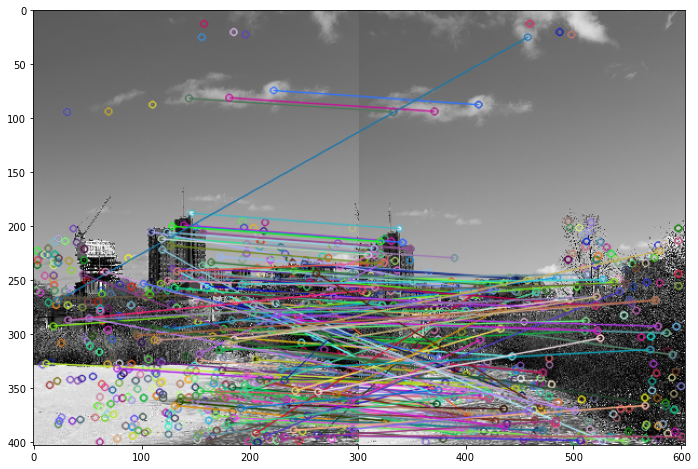

(<matplotlib.image.AxesImage at 0x1875136d0>, None)

In [111]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(descriptors2,descriptors1)
matches = sorted(matches, key = lambda x:x.distance)
print("Found "+str(len(matches))+" matches!")
img3 = cv2.drawMatches(img2, keypoints2, img1, keypoints1, matches[:], img1, flags=2)
plt.figure(figsize=(16,8))
plt.imshow(img3),plt.show()

At the moment, not all of these matches will be good; to see what this stitch would look like from homography we compute from these points, lets build out our SVD code. \
While, we're at it, lets also turn the above sift detector into a function for later and redo what we did above.

In [112]:
siftPts = namedtuple('siftPts', 'k d')
def siftDC(img):
    # take in source and destinatition photos and outputs sift detected key points and computed descriptors as an array
    sift = cv2.SIFT_create() #create our detector
    keypoints, descriptors = sift.detectAndCompute(img,None) # detect keypoints and compute descriptors

    return siftPts(keypoints,descriptors)

In [170]:
def matchMaker(d1,d2,ratio):
    # takes in keypoints and descriptors for two images and returns a sorted index of matches using bfmatcher
    # bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # matches = bf.match(d1,d2) #TODO: add knn funcitonality
    # matches = sorted(matches, key = lambda x:x.distance)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(d1,d2, k=2)
    

    # Apply ratio test
    good = []
    for m in matches:
        if m[0].distance < ratio*m[1].distance:
            good.append(m[0])

    good = sorted(good, key = lambda x:x.distance)

    return matches, good

In [171]:
def getH(dest_kp, src_kp,matches,good): # fortunately, I do SVD in part 2a so we just need to import that code
    #and modify for use with keypoints

    dest = np.array([dest_kp[mat.queryIdx].pt for mat in good])
    src = np.array([src_kp[mat.trainIdx].pt for mat in good])
    p = np.array([0,0,0,0,0,0,0,0,1])    

    for i in range(len(dest)):
        pi = np.array([[-src[i][0],-src[i][1],-1,0,0,0,src[i][0]*dest[i][0],src[i][1]*dest[i][0],dest[i][0]],
        [0,0,0,-src[i][0],-src[i][1],-1,src[i][0]*dest[i][1],src[i][1]*dest[i][1],dest[i][1]]])
        p = np.vstack((pi,p))

  
    x = np.zeros((len(dest)*2,1))
    x = np.vstack((x,np.array([1])))
    H, residuals, rank, s = np.linalg.lstsq(p,x)
    H = H.reshape((3,3))
    

    return H



In [172]:
Point = namedtuple('Point', 'x y')
def imgWarp(img,dest,H):
# warp an image but also check if its max (corner) points end up negative and shifts accordingly
    h1,w1 = img.shape[:2] #grab height and width from input image
    h2,w2 = dest.shape[:2] #grab height and width from dest image
    pts = (Point(0,0),Point(0,h1),Point(w1,h1),Point(w1,0)) #create an array of just the corners in order top left, top right, bottom left, bottom right
    transPts=[]
    for pt in pts:
        # print(np.array([pt.x,pt.y]))
        transPts.append(np.matmul(H,np.array([pt.x,pt.y,1]))) #matmul the corners by the homography
    #this little x_min/max section was inspired by the great Xavier Hubbard 
    x_min = min(pt[0]/pt[2] for pt in transPts)
    x_max = max(pt[0]/pt[2] for pt in transPts) #find minimum and maximum values for x of corners. I dont really care about y since I think keeping overal y dimension constant will look nicer.

    if x_min <0:
        x_shift = abs(x_min)
        # dim = (int(x_max+x_shift+w2),h1)

    elif x_min >0:
        x_shift = 0
        # dim = (int(x_max+x_shift+w1),h1)

    dim = (int(x_max+x_shift+w2),h1)

    print(dim)

    #lets create our new translation homography woo!

    transH = np.array([[1,0,np.ceil(x_shift)],[0,1,0],[0,0,1]])

    #now lets combine it with our original H!

    H_total=np.matmul(transH,H)
    # print(H_total)

    # #now we can warp our image AND the keypoints that correspond with it TODO: add keypoint warp
    # # np.matmul(H,np.array([pt.x,pt.y,1])))
    out_img = cv2.warpPerspective(img,H_total,dim)
    out_dest_img = cv2.warpPerspective(dest,transH,dim)
    out_mask=np.any(out_img,2)
    out_mask=np.repeat(out_mask[:,:,np.newaxis], 3, axis=2)
    out_dest_mask=np.any(out_dest_img,2)
    out_dest_mask=np.repeat(out_dest_mask[:,:,np.newaxis], 3, axis=2)
    mask_result=np.bitwise_and(out_mask,out_dest_mask).astype("uint8")
    
    
    result = cv2.addWeighted(out_img, 0.5, out_dest_img, 0.5, 0)#create our blend

    mask_result=(cv2.cvtColor(mask_result, cv2.COLOR_BGR2GRAY))

    output=cv2.bitwise_and(result,result,mask=mask_result)
    result=cv2.subtract(result,output)
    result=cv2.add(result,result)
    output2 = cv2.add(output, result)
    # cut out the extra balck space to the right of th image    
    h,w = output2.shape[:2]
    bounds=np.any(output2,2)
    edge=0
    for x in range(w-1,0,-1):
        if bounds[int(h/2), x] != 0:
            edge = x
            break
    output_im=output2[:,:edge,:]

    plt.imshow(output_im)
    
    return (output_im, H_total, transH)

In [179]:
# reload images to reset from earlier shenanigans
# image_paths=['1.jpg','2.jpg','3.jpg','4.jpg','5.jpg']
# image_paths=['i1.jpg','i2.jpg','i3.jpg','i4.jpg','i5.jpg']
image_paths=['h1.jpg','h2.jpg','h3.jpg','h4.jpg','h5.jpg']
images=[]
for image in image_paths:
    img = cv2.imread(image)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (0,0), fx=.1, fy=.1)
    images.append(img)

im2fts=siftDC(images[2])
im1fts=siftDC(images[1])
(match12,good)=matchMaker(im1fts.d,im2fts.d,0.38)
H=getH(im1fts.k,im2fts.k,match12,good)

/var/folders/xh/b9gkq_p12x95yb6qg4603lq40000gn/T/ipykernel_80586/3302232907.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H, residuals, rank, s = np.linalg.lstsq(p,x)


(721, 403)


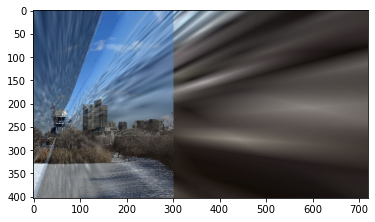

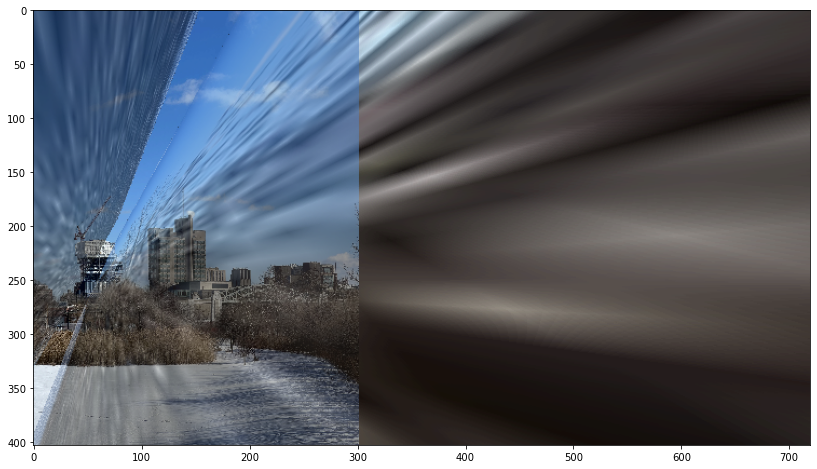

In [180]:
out,h1,h2=imgWarp(images[0],images[1],H)
plt.figure(figsize=(16,8))
plt.imshow(out)

As you can see, even with a pretty tight ratio, our results are... bad. Unfortunately doing a knn ratio check isn't going to work well for this data. In part, this is due to the our actually good features living in dense areas where our less trustworthy features, thanks to those moving clouds, are out in the open.

One way we can work on fixing this is to use RANSAC to better sort our data. Lets give that a shot!

In [156]:
# try with ransac
